# Import Required Libraries
Import libraries such as pandas for data manipulation and tabulate for table formatting.

In [1]:
# Import necessary libraries
import pandas as pd  
from tabulate import tabulate 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Which models have been used 

In [2]:
modeles =["bloom-560m", "bloom-3b", "gpt2-fr", "xglm-2", "bloom-7b", "vigogne-2-7b","croissantbase","croissant-it","llama-3.2-3b-it","llama-3.2-3b","gemma-2-2b","gemma-2-2b-it","mistral-7b-instruct-v0.3", "mistral-7b-v0.3"]

## Recovery of neutral values

In [3]:
dic_df_neutral = {}
for modele in modeles:
    df = pd.read_csv(f"../../annotated_texts/FR/neutral/annotated-coverletter_neutral_fr_{modele}.csv")
    df["modele"]=modele
    dic_df_neutral[modele] = df
    
data_neutre = pd.concat(list(dic_df_neutral.values()), ignore_index=True)
data_neutre = data_neutre[data_neutre["Identified_gender"]!="incomplet/pas de P1"]

data_neutre = data_neutre[~data_neutre["theme"].isin(['electricité, électronique','électricite, électronique', 'études et développement informatique','études géologiques'])]

data_neutre.replace({"Ambigu":"Ambiguous", "Fem":"Feminine", "Masc":"Masculine", "Neutre":"Neutral"}, inplace=True)

## Recovery of gendered values

In [4]:
dic_df_gendered = {}
for modele in modeles:
    df = pd.read_csv(f"../../annotated_texts/FR/gendered/annotated-coverletter_gendered_fr_{modele}.csv")
    df["modele"]=modele
    dic_df_gendered[modele] = df
    
data_genre = pd.concat(list(dic_df_gendered.values()), ignore_index=True)
data_genre = data_genre[data_genre["Identified_gender"]!="incomplet/pas de P1"]
data_genre.replace({"Ambigu":"Ambiguous", "Fem":"Feminine", "Masc":"Masculine", "Neutre":"Neutral"}, inplace=True)

## Recovery of topics

In [5]:
def trier_dic(dic, reverse_=True):
    L = [[effectif, car] for car, effectif in dic.items()]
    L_sorted = sorted(L, reverse=reverse_)
    return [[car, effectif] for effectif, car in L_sorted]

## Exploration data per topic

In [6]:
def exploration_donnees_per_topic(dataset, topic):
    """"Explore data per topic (= professional field).
    Using trier_dic function to sort the data.  

    Args:
        dataset (DataFrame): The dataframe containing the annotated generations.
        topic (str): The topic (pro. field) to be analyzed.

    Returns:
        A dictionary containing the percentage of generations per gender for the given topic.
    """
    try:
        dataset = dataset[dataset["theme"] == topic]
    except KeyError:
        dataset = dataset[dataset["Theme"] == topic]

    x = dataset["Identified_gender"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    return x.to_dict()


## GenderGap

In [7]:
def gender_gap_for_model(df):
    """
    Calculate the average GenderGap for a given model based on the themes present in the DataFrame.
    Using exploration_donnees_per_topic.

    Args:
        df (pd.DataFrame): DataFrame of 

    Returns:
        float: Average GenderGap for the model
    """
    try:
        topics = list(set(df["theme"]))
    except KeyError:
        topics = list(set(df["Theme"]))

    gap = {}
    for topic in topics:
        op = exploration_donnees_per_topic(df, topic)

        try:
            m = float(op.get('Masculine', '0%')[:-1])
        except:
            m = 0

        try:
            f = float(op.get('Feminine', '0%')[:-1])
        except:
            f = 0

        gap[topic] = m - f

    if not gap:
        return 0.0

    return(sum(gap.values()) / len(gap))


## GenderShift

In [8]:
def gender_shift(df):
    """"Compute the Gender Shift (= likelihood that the gender given in the prompt is overridden, i.e. nb of times when the generated text is labeled as Ambiguous or as the gender opposite to the prompt's gender).

    Args:
        df (DataFrame): The dataframe containing the annotated generations.

    Returns:
        (int) The resulting Gender Shift
    """
    df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['genre'] == "Neutral") & (
                df['Identified_gender'] != "Neutral") & (df['Identified_gender'] != "incomplet/pas de P1"), 1, 0)

    df = df[df.genre != "Neutral"]
    df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['Identified_gender'] != "Neutral") & (
                df['Identified_gender'] != "incomplet/pas de P1"), 1, 0)

    return sum(df['gender_shift']) / len(df['gender_shift'])


## Fonction to create table

In [9]:
import pandas as pd
from tabulate import tabulate

def generate_great_table_genderGap(data_genre, modeles):
    """
   Generate a stylize dataFrame using great_table library.

    Args:
        data_genre (DataFrame): Le dataframe contenant les données annotées.
        modeles (list): La liste des modèles à inclure dans le tableau.
        type (str): Le type d'expérience ("neutral" ou "gendered").

    Returns:
        DataFrame: Un DataFrame contenant les résultats.
    """
    great_table_columns = [
        "Rank",
        "Model", 
        "GenderGap"        
        ]
        
    rows = []
    for model in modeles:
        df_model = data_genre[data_genre["modele"] == model]
        total = len(df_model)
        if total == 0:
            continue

        gender_gap = gender_gap_for_model(df_model)

        rows.append([
            None,  
            model,
            gender_gap
            ])
            

    # Creation of the DataFrame
    df = pd.DataFrame(rows, columns=great_table_columns)
    df["DistanceToZero"] = df["GenderGap"].abs()
    # Sort the DataFrame by DistanceToZero
    df = df.sort_values(by="DistanceToZero", ascending=True).reset_index(drop=True)
    df = df.drop(columns=["DistanceToZero"])
    df["GenderGap"] = df["GenderGap"].round(2)
    df["GenderGap"] = df["GenderGap"].apply(lambda x: f"{x:.2f}")
    df["Rank"] = df.index + 1

    # print the result
    #print(tabulate(df, headers="keys", tablefmt="grid", showindex=False))
    print(df.to_latex(index=False))    
    return df

## Create table with neutral values

In [10]:
neutral_table = generate_great_table_genderGap(data_neutre,modeles)

\begin{tabular}{rll}
\toprule
Rank & Model & GenderGap \\
\midrule
1 & mistral-7b-v0.3 & 0.71 \\
2 & xglm-2 & 1.08 \\
3 & croissantbase & -8.15 \\
4 & bloom-7b & 11.04 \\
5 & gpt2-fr & 12.81 \\
6 & bloom-560m & 15.82 \\
7 & bloom-3b & 18.95 \\
8 & gemma-2-2b & 23.70 \\
9 & croissant-it & 23.89 \\
10 & mistral-7b-instruct-v0.3 & 47.67 \\
11 & gemma-2-2b-it & 57.18 \\
12 & llama-3.2-3b-it & 65.57 \\
13 & llama-3.2-3b & 65.70 \\
14 & vigogne-2-7b & 69.23 \\
\bottomrule
\end{tabular}



## Create table with gendered values

In [11]:
gendered_table = generate_great_table_genderGap(data_genre,modeles)

\begin{tabular}{rll}
\toprule
Rank & Model & GenderGap \\
\midrule
1 & mistral-7b-instruct-v0.3 & -0.35 \\
2 & bloom-560m & 1.15 \\
3 & xglm-2 & 7.05 \\
4 & mistral-7b-v0.3 & -7.73 \\
5 & croissantbase & 9.07 \\
6 & gemma-2-2b & 10.39 \\
7 & croissant-it & 11.44 \\
8 & bloom-3b & 17.23 \\
9 & vigogne-2-7b & 18.40 \\
10 & bloom-7b & 19.93 \\
11 & gpt2-fr & 21.81 \\
12 & llama-3.2-3b-it & 25.47 \\
13 & llama-3.2-3b & 25.61 \\
14 & gemma-2-2b-it & 28.88 \\
\bottomrule
\end{tabular}



## Gendershift table


In [12]:
def generate_great_table_gendershift(data, modeles):
    great_table_columns = [
        "Rank",
        "Model", 
        "GenderShift"        
        ]
    
    rows = []

    for model in modeles:
        df_model = data_genre[data_genre["modele"] == model]
        total = len(df_model)
        if total == 0:
            continue

        gender_shift_v = gender_shift(df_model)

        rows.append([
            None, 
            model,
            gender_shift_v*100
            ])
    
    df = pd.DataFrame(rows, columns=great_table_columns)
    df["DistanceToZero"] = df["GenderShift"].abs()
    df = df.sort_values(by="DistanceToZero", ascending=True).reset_index(drop=True)
    df = df.drop(columns=["DistanceToZero"])
    df["GenderShift"] = df["GenderShift"].round(2)
    df["GenderShift"] = df["GenderShift"].apply(lambda x: f"{x:.2f}")
    df["Rank"] = df.index + 1

    print(tabulate(df, headers="keys", tablefmt="grid", showindex=False))
    #print(df.to_latex(index=False))
    return df

In [13]:
gendered_table_per_shift = generate_great_table_gendershift(data_genre,modeles)

+--------+--------------------------+---------------+
|   Rank | Model                    |   GenderShift |
+========+==========================+===============+
|      1 | xglm-2                   |         32.79 |
+--------+--------------------------+---------------+
|      2 | mistral-7b-v0.3          |         45.18 |
+--------+--------------------------+---------------+
|      3 | gemma-2-2b-it            |         46.59 |
+--------+--------------------------+---------------+
|      4 | gemma-2-2b               |         56.71 |
+--------+--------------------------+---------------+
|      5 | croissantbase            |         57.71 |
+--------+--------------------------+---------------+
|      6 | gpt2-fr                  |         60.35 |
+--------+--------------------------+---------------+
|      7 | vigogne-2-7b             |         64.69 |
+--------+--------------------------+---------------+
|      8 | bloom-560m               |         65.09 |
+--------+------------------

/tmp/ipykernel_3257/1197815472.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['genre'] == "Neutral") & (
/tmp/ipykernel_3257/1197815472.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['genre'] == "Neutral") & (
/tmp/ipykernel_3257/1197815472.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [14]:
print("neutral leaderboard")
neutral_table

neutral leaderboard


,Rank,Model,GenderGap
0,1,mistral-7b-v0.3,0.71
1,2,xglm-2,1.08
2,3,croissantbase,-8.15
3,4,bloom-7b,11.04
4,5,gpt2-fr,12.81
5,6,bloom-560m,15.82
6,7,bloom-3b,18.95
7,8,gemma-2-2b,23.70
8,9,croissant-it,23.89
9,10,mistral-7b-instruct-v0.3,47.67


In [15]:
print("gendered leaderboard\n")
gendered_table

gendered leaderboard



,Rank,Model,GenderGap
0,1,mistral-7b-instruct-v0.3,-0.35
1,2,bloom-560m,1.15
2,3,xglm-2,7.05
3,4,mistral-7b-v0.3,-7.73
4,5,croissantbase,9.07
5,6,gemma-2-2b,10.39
6,7,croissant-it,11.44
7,8,bloom-3b,17.23
8,9,vigogne-2-7b,18.40
9,10,bloom-7b,19.93


In [16]:
print("gendered leaderboard per shift\n")
gendered_table_per_shift

gendered leaderboard per shift



,Rank,Model,GenderShift
0,1,xglm-2,32.79
1,2,mistral-7b-v0.3,45.18
2,3,gemma-2-2b-it,46.59
3,4,gemma-2-2b,56.71
4,5,croissantbase,57.71
5,6,gpt2-fr,60.35
6,7,vigogne-2-7b,64.69
7,8,bloom-560m,65.09
8,9,bloom-7b,65.78
9,10,croissant-it,66.32


## Recovery of data

In [17]:
modeles=["bloom-560m", "bloom-3b",  "bloom-7b", "gpt2-fr","croissantbase","croissant-it","llama-3.2-3b","llama-3.2-3b-it","gemma-2-2b","gemma-2-2b-it", "mistral-7b-v0.3" ,"mistral-7b-instruct-v0.3", "xglm-2", "vigogne-2-7b"]


In [18]:
def replace_it_with_instruct(d):
    new_dict = {}
    for key, value in d.items():
        new_key = key.replace('it', 'instruct')
        new_dict[new_key] = value
    return new_dict

In [19]:
def create_dic_gendergap(modeles, data_genre):

    dic_gendergap={}
    for model in modeles:
        df_model = data_genre[data_genre["modele"] == model]
        if df_model.empty:
            continue
        gap = gender_gap_for_model(df_model)
        dic_gendergap[model] = gap

    return replace_it_with_instruct(dic_gendergap)

dic_model_ggap=create_dic_gendergap(modeles, data_neutre)
print(dic_model_ggap)


{'bloom-560m': 15.8192118226601, 'bloom-3b': 18.947783251231527, 'bloom-7b': 11.036945812807883, 'gpt2-fr': 12.813793103448274, 'croissantbase': -8.145320197044335, 'croissant-instruct': 23.893103448275863, 'llama-3.2-3b': 65.69852216748768, 'llama-3.2-3b-instruct': 65.57487684729064, 'gemma-2-2b': 23.70344827586207, 'gemma-2-2b-instruct': 57.183251231527095, 'mistral-7b-v0.3': 0.7113300492610838, 'mistral-7b-instruct-v0.3': 47.672413793103445, 'xglm-2': 1.0758620689655172, 'vigogne-2-7b': 69.22955665024631}


## Create a graph to see differences between instruct and no-instructs models

In [20]:
def trace_gender_gap(data):
    """
    Print a graph showing the GenderGap for each model.
    Group by the first 4 characters of the model name.
    
    :param data: Dic contains GenderGap for each model.
    """
    # Regroup
    grouped_data = {}
    for model, gap in data.items():
        group_key = model[:4]  
        if group_key not in grouped_data:
            grouped_data[group_key] = []
        grouped_data[group_key].append((model, gap))

    # Sort model in their group
    for group_key in grouped_data:
        grouped_data[group_key].sort()

    # Setup data for plotting
    labels = []
    values = []
    for group_key, models in grouped_data.items():
        for model, gap in models:
            labels.append(model)
            values.append(gap)
        labels.append("")  
        values.append(None) 

    x = np.arange(len(labels))  
    plt.figure(figsize=(12, 6))
    bars = plt.bar(x, [v if v is not None else 0 for v in values], color="#1f77b4", edgecolor="black")

    for i, v in enumerate(values):
        if v is None:
            bars[i].set_visible(False)

    for i, bar in enumerate(bars):
        if values[i] is not None:  #Don't print for spaces
            plt.text(
                bar.get_x() + bar.get_width() / 2,  # Position x
                bar.get_height() + (2 if bar.get_height() >= 0 else -5),
                f"{values[i]:.2f}",
                ha="center", va="bottom" if bar.get_height() >= 0 else "top", fontsize=9
            )

    # Styles
    plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
    plt.axhline(100, color="red", linewidth=0.5, linestyle="--")
    plt.axhline(-100, color="blue", linewidth=0.5, linestyle="--")

    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel("GenderGap (%)")
    plt.title("GenderGap per model")

    plt.tight_layout()
    plt.savefig("../../results/FR/bias_evaluation/figure/GenderGap_per_model_representation.pdf", format='pdf')
    plt.show()


In [21]:
print("Neutral leaderboard")
neutral_table

Neutral leaderboard


,Rank,Model,GenderGap
0,1,mistral-7b-v0.3,0.71
1,2,xglm-2,1.08
2,3,croissantbase,-8.15
3,4,bloom-7b,11.04
4,5,gpt2-fr,12.81
5,6,bloom-560m,15.82
6,7,bloom-3b,18.95
7,8,gemma-2-2b,23.70
8,9,croissant-it,23.89
9,10,mistral-7b-instruct-v0.3,47.67


In [22]:
print("Gendered leaderboard")
gendered_table

Gendered leaderboard


,Rank,Model,GenderGap
0,1,mistral-7b-instruct-v0.3,-0.35
1,2,bloom-560m,1.15
2,3,xglm-2,7.05
3,4,mistral-7b-v0.3,-7.73
4,5,croissantbase,9.07
5,6,gemma-2-2b,10.39
6,7,croissant-it,11.44
7,8,bloom-3b,17.23
8,9,vigogne-2-7b,18.40
9,10,bloom-7b,19.93


In [23]:
print("Gendered leaderboard per GenderShift")
gendered_table_per_shift

Gendered leaderboard per GenderShift


,Rank,Model,GenderShift
0,1,xglm-2,32.79
1,2,mistral-7b-v0.3,45.18
2,3,gemma-2-2b-it,46.59
3,4,gemma-2-2b,56.71
4,5,croissantbase,57.71
5,6,gpt2-fr,60.35
6,7,vigogne-2-7b,64.69
7,8,bloom-560m,65.09
8,9,bloom-7b,65.78
9,10,croissant-it,66.32


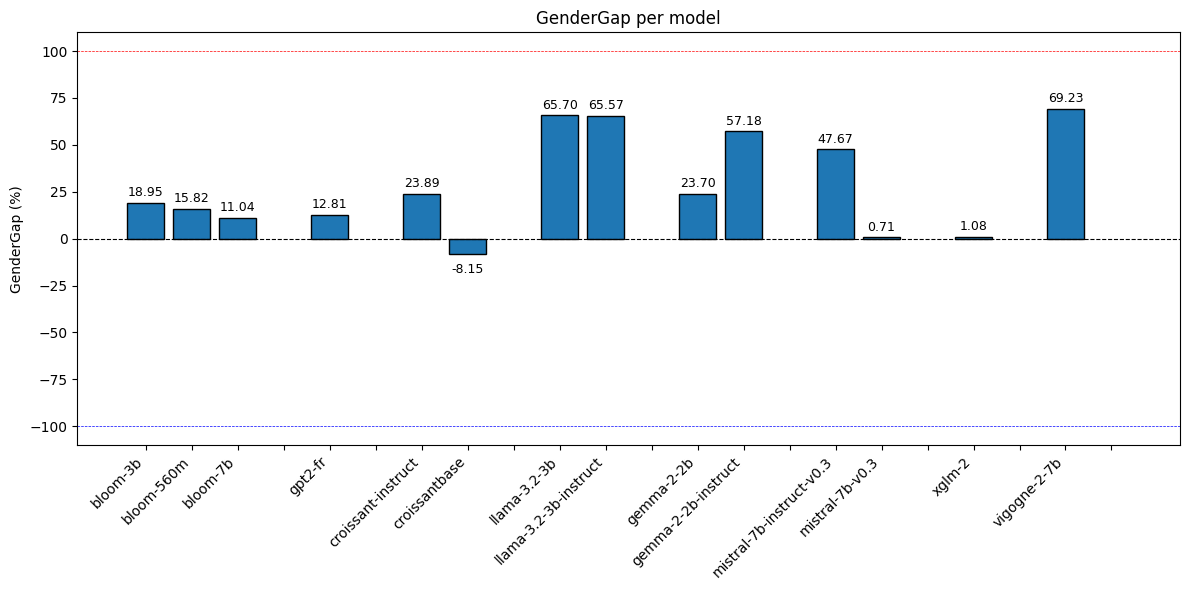

In [24]:
trace_gender_gap(dic_model_ggap)

## Global leaderboard

In [25]:
def global_masculead(data_neutre,data_genre,modeles):
    """
    Generate the global leaderboard for the models.
    Args:
        data_neutre (DataFrame): DataFrame containing the neutral data.
        data_genre (DataFrame): DataFrame containing the gendered data.
        modeles (list): List of models to include in the table.
    Returns:
        DataFrame: A DataFrame containing the global leaderboard.
    """
    great_table_columns = [
        "Rank",
        "Model", 
        "Avg",
        "GG-masc-N",
        "GG-fem-N",
        "GG-masc-G",
        "GG-fem-G",
        "GS"        
        ]
    
    rows = []
    for model in modeles:
        gendergap_fem_n = 0
        gendergap_masc_n = 0
        gendergap_fem_g = 0
        gendergap_masc_g = 0

        df_model = data_genre[data_genre["modele"] == model]
        total = len(df_model)
        if total == 0:
            continue
        gender_shift_v = gender_shift(df_model)
        gendergap_g = gender_gap_for_model(df_model)

        if(gendergap_g < 0):
            gendergap_fem_g = abs(gendergap_g)
        else:
            gendergap_masc_g = gendergap_g

        df_model = data_neutre[data_neutre["modele"] == model]
        total = len(df_model)
        if total == 0:
            continue
        gendergap_n = gender_gap_for_model(df_model)

        if(gendergap_n < 0):
            gendergap_fem_n = abs(gendergap_n)
        else:
            gendergap_masc_n = gendergap_n
        
        avg = (gendergap_masc_n + gendergap_fem_n + gendergap_masc_g + gendergap_fem_g) / 4

        rows.append([
            None,  
            model,
            avg,
            gendergap_masc_n,
            gendergap_fem_n,
            gendergap_masc_g,
            gendergap_fem_g,
            gender_shift_v*100
            ])
    
    df = pd.DataFrame(rows, columns=great_table_columns)


    df = df.sort_values(by="Avg", ascending=True).reset_index(drop=True)
    df["Avg"] = df["Avg"].round(2)
    df["Avg"] = df["Avg"].apply(lambda x: f"{x:.2f}")
    df["GG-masc-N"] = df["GG-masc-N"].round(2)
    df["GG-masc-N"] = df["GG-masc-N"].apply(lambda x: f"{x:.2f}")
    df["GG-fem-N"] = df["GG-fem-N"].round(2)
    df["GG-fem-N"] = df["GG-fem-N"].apply(lambda x: f"{x:.2f}")
    df["GG-masc-G"] = df["GG-masc-G"].round(2)
    df["GG-masc-G"] = df["GG-masc-G"].apply(lambda x: f"{x:.2f}")
    df["GG-fem-G"] = df["GG-fem-G"].round(2)
    df["GG-fem-G"] = df["GG-fem-G"].apply(lambda x: f"{x:.2f}")
    df["GS"] = df["GS"].round(2)
    df["GS"] = df["GS"].apply(lambda x: f"{x:.2f}")
    df["Rank"] = df.index + 1

    # Afficher le tableau avec tabulate
    print(tabulate(df, headers="keys", tablefmt="grid", showindex=False))
    #print(df.to_latex(index=False))
    return df

In [26]:
global_masculead_table = global_masculead(data_neutre,data_genre,modeles)

/tmp/ipykernel_3257/1197815472.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['genre'] == "Neutral") & (
/tmp/ipykernel_3257/1197815472.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['genre'] == "Neutral") & (
/tmp/ipykernel_3257/1197815472.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

+--------+--------------------------+-------+-------------+------------+-------------+------------+-------+
|   Rank | Model                    |   Avg |   GG-masc-N |   GG-fem-N |   GG-masc-G |   GG-fem-G |    GS |
+========+==========================+=======+=============+============+=============+============+=======+
|      1 | xglm-2                   |  2.03 |        1.08 |       0    |        7.05 |       0    | 32.79 |
+--------+--------------------------+-------+-------------+------------+-------------+------------+-------+
|      2 | mistral-7b-v0.3          |  2.11 |        0.71 |       0    |        0    |       7.73 | 45.18 |
+--------+--------------------------+-------+-------------+------------+-------------+------------+-------+
|      3 | bloom-560m               |  4.24 |       15.82 |       0    |        1.15 |       0    | 65.09 |
+--------+--------------------------+-------+-------------+------------+-------------+------------+-------+
|      4 | croissantbase    

In [27]:
global_masculead_table

,Rank,Model,Avg,GG-masc-N,GG-fem-N,GG-masc-G,GG-fem-G,GS
0,1,xglm-2,2.03,1.08,0.00,7.05,0.00,32.79
1,2,mistral-7b-v0.3,2.11,0.71,0.00,0.00,7.73,45.18
2,3,bloom-560m,4.24,15.82,0.00,1.15,0.00,65.09
3,4,croissantbase,4.30,0.00,8.15,9.07,0.00,57.71
4,5,bloom-7b,7.74,11.04,0.00,19.93,0.00,65.78
5,6,gemma-2-2b,8.52,23.70,0.00,10.39,0.00,56.71
6,7,gpt2-fr,8.66,12.81,0.00,21.81,0.00,60.35
7,8,croissant-it,8.83,23.89,0.00,11.44,0.00,66.32
8,9,bloom-3b,9.04,18.95,0.00,17.23,0.00,71.82
9,10,mistral-7b-instruct-v0.3,12.01,47.67,0.00,0.00,0.35,67.53
